In [1]:
import pandas as pd
import pickle
import torch.nn.functional as F
# from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.transforms as mtrans
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils import data
from IF import *
from proutils import *
from joblib import Parallel, delayed
from aix360.algorithms.protodash import ProtodashExplainer

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import Counter
from image_explainer import *


def surrogate_fidelity(prototypes):
    smodel = fit_model(X_test[prototypes], mod_pred[prototypes])

    # Evaluate the model on test data
    smodel.eval()
    with torch.no_grad():
        outputs = smodel(X_test)
        predicted = (outputs>0.5).int()
        accuracy = (predicted == mod_pred).sum().item() / len(Y_test)
    return accuracy
dmem=torch.load('data/embeds_DMdog.pt')

In [2]:
# embeds = load_inception_embeds()
embeds = torch.load('data/dogfishembeds.pt')

X_train = torch.tensor(embeds["X_train"])
Y_train = torch.tensor(embeds["Y_train"])

X_test = torch.tensor(embeds["X_test"])
Y_test = torch.tensor(embeds["Y_test"])

/tmp/ipykernel_2899964/3505807050.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeds = torch.load('data/dogfishembeds.pt')


In [7]:
L2_WEIGHT = 1e-4
class BinClassObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.binary_cross_entropy(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.binary_cross_entropy(outputs, batch[1])
torch.manual_seed(8)
module = LiSSAInfluenceModule(
    model=clf,
    objective=BinClassObjective(),
    train_loader=data.DataLoader(train_set, batch_size=32),
    test_loader=data.DataLoader(test_set, batch_size=32),
    device=DEVICE,
    damp=0.001,
    repeat= 1,
    depth=1800,
    scale= 10,
)
train_idxs = list(range(X_train.shape[0]))


In [3]:
L2_WEIGHT = 1e-4
def fit_model(X, Y):
    C = 1 / (X.shape[0] * L2_WEIGHT)
    sk_clf = linear_model.LogisticRegression(C=C, tol=1e-8, max_iter=1000)
    sk_clf = sk_clf.fit(X.numpy(), Y.numpy())

    # recreate model in PyTorch
    fc = nn.Linear(768, 1, bias=True)
    fc.weight = nn.Parameter(torch.tensor(sk_clf.coef_))
    fc.bias = nn.Parameter(torch.tensor(sk_clf.intercept_))

    pt_clf = nn.Sequential(
        fc,
        nn.Flatten(start_dim=-2),
        nn.Sigmoid()
    )

    return pt_clf.type('torch.FloatTensor')

train_set = data.TensorDataset(X_train, Y_train)
test_set = data.TensorDataset(X_test, Y_test)
torch.manual_seed(42)
clf = fit_model(X_train, Y_train)

In [4]:
mod_pred = (clf(X_test)>0.5).int()
DEVICE= torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
with torch.no_grad():
    outputs = clf(X_test)
    predicted = (outputs>0.5).int()
    accuracy = (predicted == Y_test).sum().item() / len(Y_test)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 98.67%


In [6]:
test_idxs = list(range(len(Y_test)))
train_idxs = list(range(len(Y_train)))

In [17]:
# Function to compute influence for a single test point
def compute_influence(test_idx):
    # print(f'Compute influence for test point {test_idx}')
    influences = module.influences(train_idxs=train_idxs, test_idxs=[test_idx])
    return influences.numpy()

# Parallel computation of influence scores
num_cores = -1

influence_scores = Parallel(n_jobs=num_cores)(delayed(compute_influence)(test_idx) for test_idx in tqdm(test_idxs))

# Step 7: Save the influence scores to a file
influence_scores = np.array(influence_scores)
# np.save('influence_scores_dogfish.npy', influence_scores)
print('Influence scores saved to influence_scores.npy')

100%|██████████| 600/600 [03:57<00:00,  2.53it/s]
/tmp/ipykernel_2861197/3653095824.py:13: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  influence_scores = np.array(influence_scores)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (600,) + inhomogeneous part.

In [8]:
influence_scores=np.load('data/influence_scores_dogfish.npy')

100%|██████████| 8/8 [00:00<00:00, 6171.50it/s]


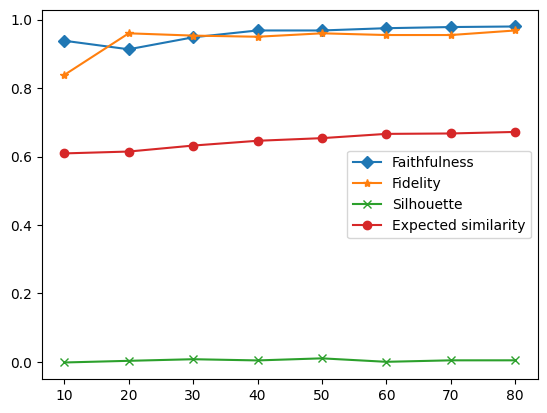

In [24]:
#Experiments with MGloP
mglop=Parallel(n_jobs=-1)(delayed(find_representative_samples)(X_test, X_train, influence_scores,i, 20) for i in tqdm(range(10,81,10)))
accs=[]
fids=[]
sil=[]
sim=[]
def compute_metrics(i):
    acc = nearest_medoid_accuracy(X_test, mod_pred, mglop[i])
    fid=surrogate_fidelity(mglop[i])
    sil = compute_prototype_silhouette_score(X_test, mglop[i])
    labels = cluster_by_prototypes(X_test, mglop[i])
    sim = expected_inter_cluster_similarity(X_test, labels)
    return acc,fid, sil, sim

# Parallel computation
results = Parallel(n_jobs=64)(delayed(compute_metrics)(i) for i in range(len(mglop)))

# Unpack results into separate lists
accs,fids, sil, sim = zip(*results)
plt.plot(range(10, 81, 10), accs, marker='D', label='Faithfulness')
plt.plot(range(10, 81, 10), fids, marker='*', label='Fidelity')
plt.plot(range(10, 81, 10), sil, marker='x', label='Silhouette')
plt.plot(range(10, 81, 10), sim, marker='o', label='Expected similarity')
plt.legend()
plt.show()

### Sensetivity Analysis of MGloP

100%|██████████| 10/10 [00:00<00:00, 382.30it/s]


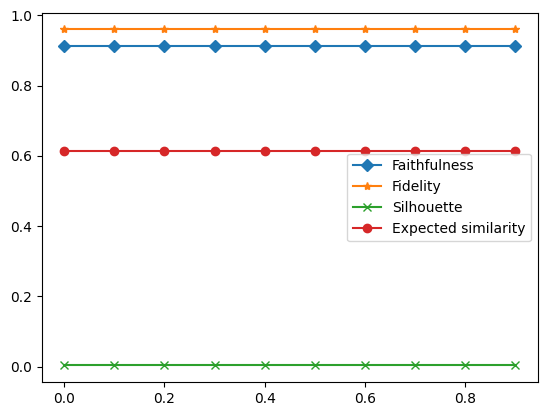

In [9]:
#Experiments with MGloP
alphas=np.arange(0,1,0.1)
mglop=Parallel(n_jobs=-1)(delayed(find_representative_samples)(X_test, X_train, influence_scores,20, 20, alpha=i) for i in tqdm(alphas))
accs=[]
fids=[]
sil=[]
sim=[]
def compute_metrics(i):
    acc = nearest_medoid_accuracy(X_test, mod_pred, mglop[i])
    fid=surrogate_fidelity(mglop[i])
    sil = compute_prototype_silhouette_score(X_test, mglop[i])
    labels = cluster_by_prototypes(X_test, mglop[i])
    sim = expected_inter_cluster_similarity(X_test, labels)
    return acc,fid, sil, sim

# Parallel computation
results = Parallel(n_jobs=64)(delayed(compute_metrics)(i) for i in range(len(mglop)))

# Unpack results into separate lists
accs,fids, sil, sim = zip(*results)
plt.plot(alphas, accs, marker='D', label='Faithfulness')
plt.plot(alphas, fids, marker='*', label='Fidelity')
plt.plot(alphas, sil, marker='x', label='Silhouette')
plt.plot(alphas, sim, marker='o', label='Expected similarity')
plt.legend()
plt.show()

100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


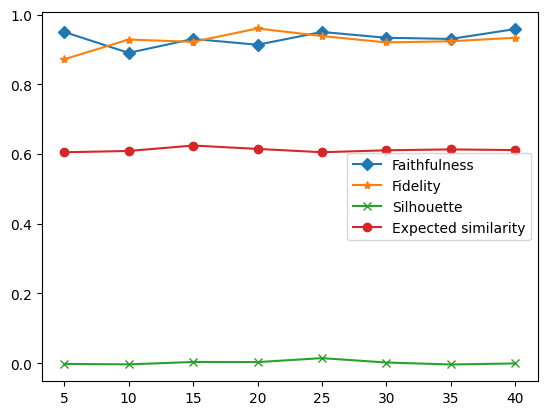

In [10]:
#Sensitivity to the number of influential sample to build the graph with
mglop=Parallel(n_jobs=-1)(delayed(find_representative_samples)(X_test, X_train, influence_scores,20, i, alpha=0.6) for i in tqdm(range(5,41,5)))
accs=[]
fids=[]
sil=[]
sim=[]
def compute_metrics(i):
    acc = nearest_medoid_accuracy(X_test, mod_pred, mglop[i])
    fid=surrogate_fidelity(mglop[i])
    sil = compute_prototype_silhouette_score(X_test, mglop[i])
    labels = cluster_by_prototypes(X_test, mglop[i])
    sim = expected_inter_cluster_similarity(X_test, labels)
    return acc,fid, sil, sim

# Parallel computation
results = Parallel(n_jobs=64)(delayed(compute_metrics)(i) for i in range(len(mglop)))

# Unpack results into separate lists
accs,fids, sil, sim = zip(*results)
plt.plot(range(5,41,5), accs, marker='D', label='Faithfulness')
plt.plot(range(5,41,5), fids, marker='*', label='Fidelity')
plt.plot(range(5,41,5), sil, marker='x', label='Silhouette')
plt.plot(range(5,41,5), sim, marker='o', label='Expected similarity')
plt.legend()
plt.show()

In [50]:
aide_em=aide(influence_scores, X_train, X_test, 20, coverage=True)
# prs=find_representative_samples(X_test, X_train, influence_scores, 20, 20, alpha=0.6)


def coverage(prots,N=30, bin=False, popularity=True):
    distances = cosine_similarity(X_test, X_test[prots])
    nearest_medoid_indices = np.argmax(distances, axis=1)
    covs=[]
    for i in np.unique(nearest_medoid_indices):
        idx=np.where(nearest_medoid_indices == i)[0]
        if popularity:
            gx=[i[0] for i in Counter(np.array(aide_em)[idx].flatten()).most_common(40)]
        else:
            gx=aide_em[prots[i]]
        for j in idx:
            if bin:
                if len(set(aide_em[j]).intersection(set(gx)))>N:
                    covs.append(1)
                else:
                    covs.append(0)
            else:
                covs.append(len(set(aide_em[j]).intersection(set(gx)))/len(aide_em[j]))
    return sum(covs)/len(covs)



In [1]:
all_protos_np=np.array(all_protos)
mglop_cov=[]
mglop2_cov=[]
protodash_cov=[]
dknn_cov=[]
dmodels_cov=[]
for i in range(len(all_protos_np)):
    mglop_cov.append(coverage(list(all_protos_np[i].values())[0],N=10, bin=True, popularity=True))
    mglop2_cov.append(coverage(list(all_protos_np[i].values())[1],N=10, bin=True, popularity=True))
    dknn_cov.append(coverage(list(all_protos_np[i].values())[2],N=10, bin=True, popularity=True))
    dmodels_cov.append(coverage(list(all_protos_np[i].values())[3],N=10, bin=True, popularity=True))
    protodash_cov.append(coverage(list(all_protos_np[i].values())[4],N=10, bin=True, popularity=True))
   


N_range=range(10,81,10)
plt.figure(figsize=(12, 8))
plt.plot(N_range, mglop_cov, marker='o', linestyle='-', label='MGLop Coverage')
plt.plot(N_range, mglop2_cov, marker='o', linestyle='-', label='MGLop2 Coverage')
plt.plot(N_range, dknn_cov, marker='s', linestyle='-', label='DKNN Coverage')
plt.plot(N_range, dmodels_cov, marker='D', linestyle='-', label='DModels Coverage')
plt.plot(N_range, protodash_cov, marker='^', linestyle='-', label='Protodash Coverage')

plt.xlabel("Number of Prototypes (N)", fontsize=16)
plt.ylabel("Coverage", fontsize=16)
plt.title("Coverage vs Number of Prototypes (N) for Different Algorithms", fontsize=18)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

NameError: name 'np' is not defined

In [27]:
N_values=range(10,81, 10)
def generate_prototypes(N):
    explainer = ProtodashExplainer()
    weights, protodash, _ = explainer.explain(X_test, X_test, m=N, kernelType='euclid')
    
    return {
        "mglop": find_representative_samples(X_test, X_train, influence_scores, N, 20),
        "mglop2": find_representative_samples(X_test, X_train, influence_scores, N, 20, alpha=0.5),
        "dknn": find_prototypes(X_test, mod_pred, N),
        "dm": find_prototypes(dmem, mod_pred, N),
        "protodash": protodash
    }

n_jobs = -1 
all_protos = Parallel(n_jobs=n_jobs)(
    delayed(generate_prototypes)(N)
    for N in tqdm(N_values)
)

100%|██████████| 8/8 [00:00<00:00, 7810.62it/s]


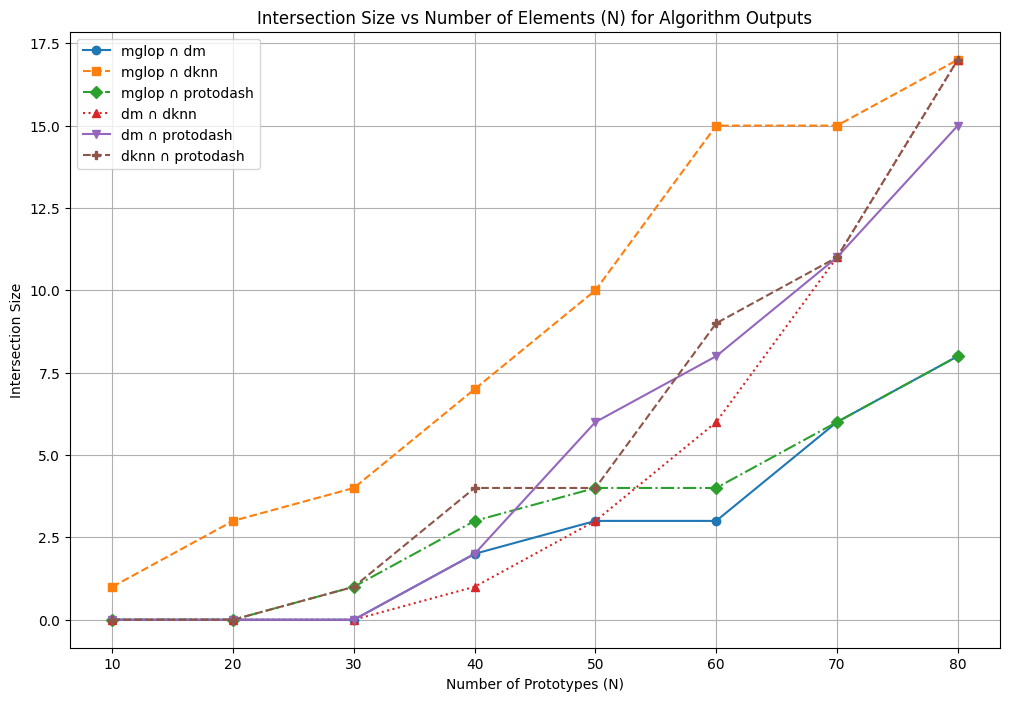

In [28]:
algorithms = ['mglop', 'mglop2', 'dm', 'dknn', 'protodash']
N_values = range(10, 101, 10)  # Increasing N values from 10 to 80
intersections = {f"{algo1} ∩ {algo2}": [] for i, algo1 in enumerate(algorithms) for algo2 in algorithms[i + 1:]}


# Extract intersections between algorithm outputs
for i, outputs in enumerate(all_protos):
    for j, algo1 in enumerate(algorithms):
        for algo2 in algorithms[j + 1:]:
            intersection_size = len(set(outputs[algo1]) & set(outputs[algo2]))
            intersections[f"{algo1} ∩ {algo2}"].append(intersection_size)

# Plotting the results
line_styles = ['-', '--', '-.', ':', '-', '--']
markers = ['o', 's', 'D', '^', 'v', 'P']

plt.figure(figsize=(12, 8))
for (label, sizes), linestyle, marker in zip(intersections.items(), line_styles, markers):
    plt.plot(N_values, sizes, linestyle=linestyle, marker=marker, label=label)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Intersection Size")
plt.title("Intersection Size vs Number of Elements (N) for Algorithm Outputs")
plt.legend()
plt.grid(True)

# Save the plot as a PDF
# plt.savefig("Figures/intersection_plot.pdf", format="pdf")

# Show the plot
plt.show()

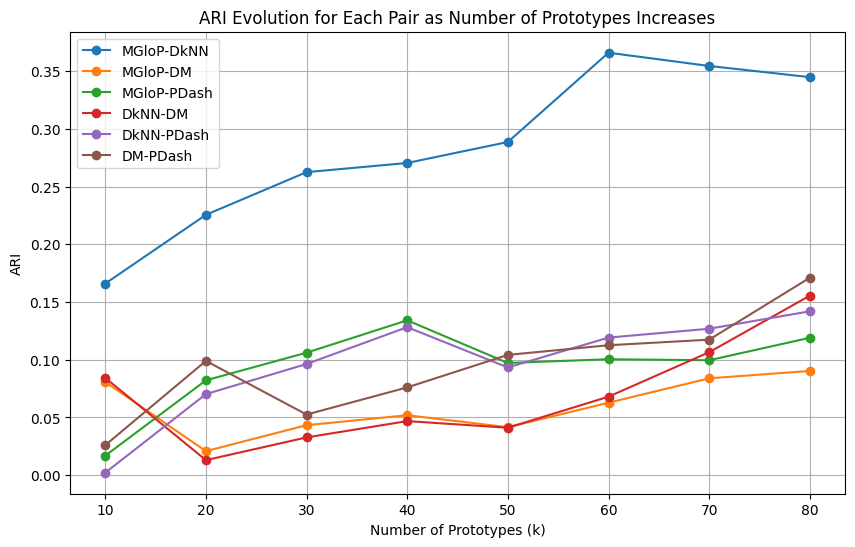

In [29]:
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist

def assign_clusters(X, prototypes):

    # Compute distance from each point to each prototype
    distances = cdist(X, prototypes, metric='euclidean')
    
    # Assign each point to the cluster with minimum distance
    labels = np.argmin(distances, axis=1)
    return labels

pairwise_aris = {
    "MGloP-DkNN": [],
    "MGloP-DM": [],
    "MGloP-PDash": [],
    "DkNN-DM": [],
    "DkNN-PDash": [],
    "DM-PDash": []
}

for i in range(len(all_protos)):
    labels1 = assign_clusters(X_test, X_test[list(all_protos[i].values())[0]])
    labels2 = assign_clusters(X_test, X_test[list(all_protos[i].values())[1]])
    labels3 = assign_clusters(X_test, X_test[list(all_protos[i].values())[2]])
    labels4 = assign_clusters(X_test, X_test[list(all_protos[i].values())[3]])
    
    
    # Compute ARIs for all pairs
    ari_12 = adjusted_rand_score(labels1, labels2)
    ari_13 = adjusted_rand_score(labels1, labels3)
    ari_14 = adjusted_rand_score(labels1, labels4)
    ari_23 = adjusted_rand_score(labels2, labels3)
    ari_24 = adjusted_rand_score(labels2, labels4)
    ari_34 = adjusted_rand_score(labels3, labels4)
    
    # Append results
    pairwise_aris["MGloP-DkNN"].append(ari_12)
    pairwise_aris["MGloP-DM"].append(ari_13)
    pairwise_aris["MGloP-PDash"].append(ari_14)
    pairwise_aris["DkNN-DM"].append(ari_23)
    pairwise_aris["DkNN-PDash"].append(ari_24)
    pairwise_aris["DM-PDash"].append(ari_34)

# Plot the ARI evolution for each pair
plt.figure(figsize=(10, 6))
for pair_name, ari_values in pairwise_aris.items():
    plt.plot(N_values, ari_values, marker='o', label=pair_name)

plt.title('ARI Evolution for Each Pair as Number of Prototypes Increases')
plt.xlabel('Number of Prototypes (k)')
plt.ylabel('ARI')
plt.grid(True)
plt.legend()
plt.show()

In [32]:
all_protos_np=np.array(all_protos)
mglop_ev=[]
protodash_ev=[]
dknn_ev=[]
dmodels_ev=[]
for i in range(len(all_protos_np)):
    mglop_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[0]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[0]), surrogate_fidelity(list(all_protos_np[i].values())[0])])
    dmodels_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[2]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[2]), surrogate_fidelity(list(all_protos_np[i].values())[2])])   
    dknn_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[1]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[1]),surrogate_fidelity(list(all_protos_np[i].values())[1])])
    protodash_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[3]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[3]), surrogate_fidelity(list(all_protos_np[i].values())[3])])
               


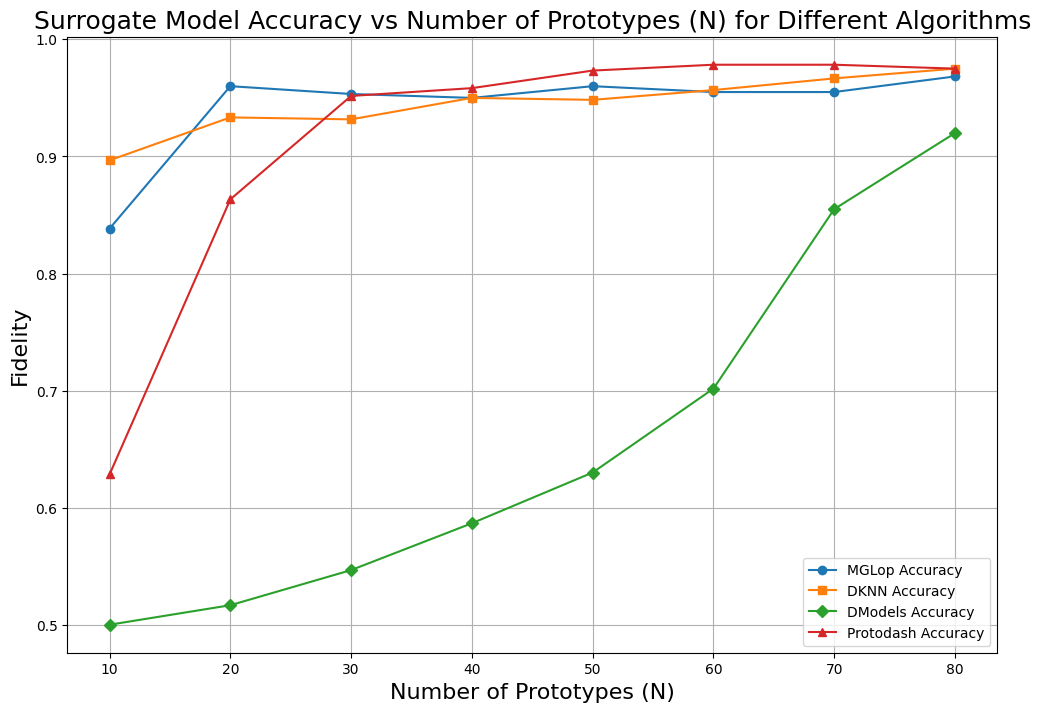

In [33]:
N_range=range(10,81,10)
plt.figure(figsize=(12, 8))
plt.plot(N_range, [item[2] for item in mglop_ev], marker='o', linestyle='-', label='MGLop Accuracy')
plt.plot(N_range, [item[2] for item in dknn_ev], marker='s', linestyle='-', label='DKNN Accuracy')
plt.plot(N_range, [item[2] for item in dmodels_ev], marker='D', linestyle='-', label='DModels Accuracy')
plt.plot(N_range, [item[2] for item in protodash_ev], marker='^', linestyle='-', label='Protodash Accuracy')

plt.xlabel("Number of Prototypes (N)", fontsize=16)
plt.ylabel("Fidelity", fontsize=16)
plt.title("Surrogate Model Accuracy vs Number of Prototypes (N) for Different Algorithms", fontsize=18)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

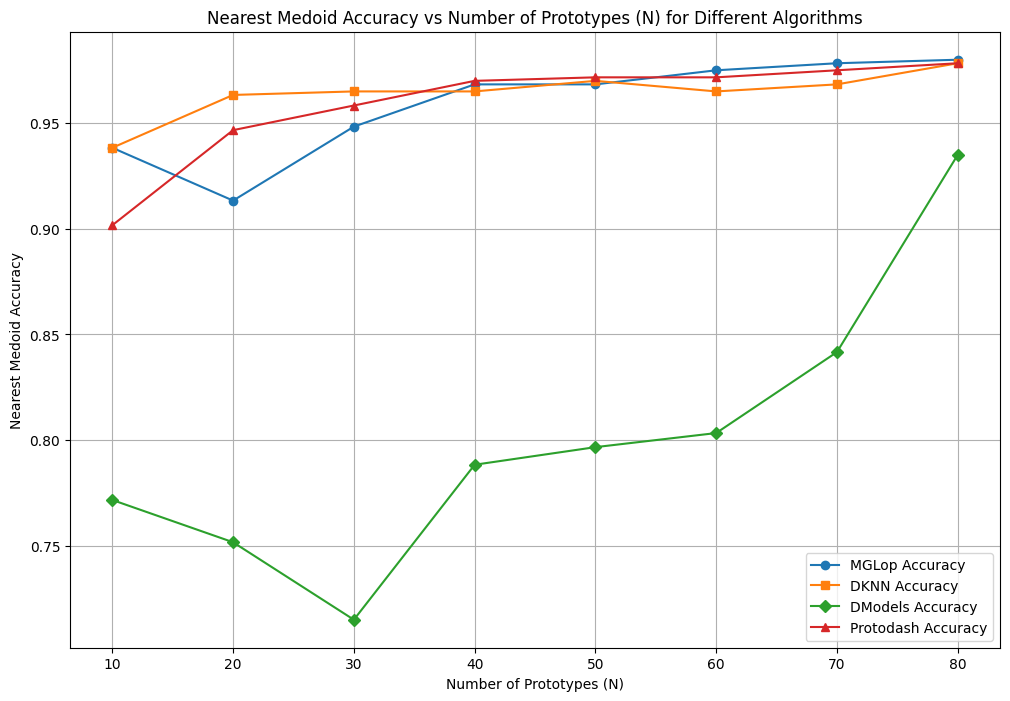

In [34]:
N_range=range(10,81,10)
plt.figure(figsize=(12, 8))
plt.plot(N_range, [item[0] for item in mglop_ev], marker='o', linestyle='-', label='MGLop Accuracy')
plt.plot(N_range, [item[0] for item in dknn_ev], marker='s', linestyle='-', label='DKNN Accuracy')
plt.plot(N_range, [item[0] for item in dmodels_ev], marker='D', linestyle='-', label='DModels Accuracy')
plt.plot(N_range, [item[0] for item in protodash_ev], marker='^', linestyle='-', label='Protodash Accuracy')

plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Nearest Medoid Accuracy")
plt.title("Nearest Medoid Accuracy vs Number of Prototypes (N) for Different Algorithms")
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

100%|██████████| 8/8 [00:02<00:00,  3.99it/s]


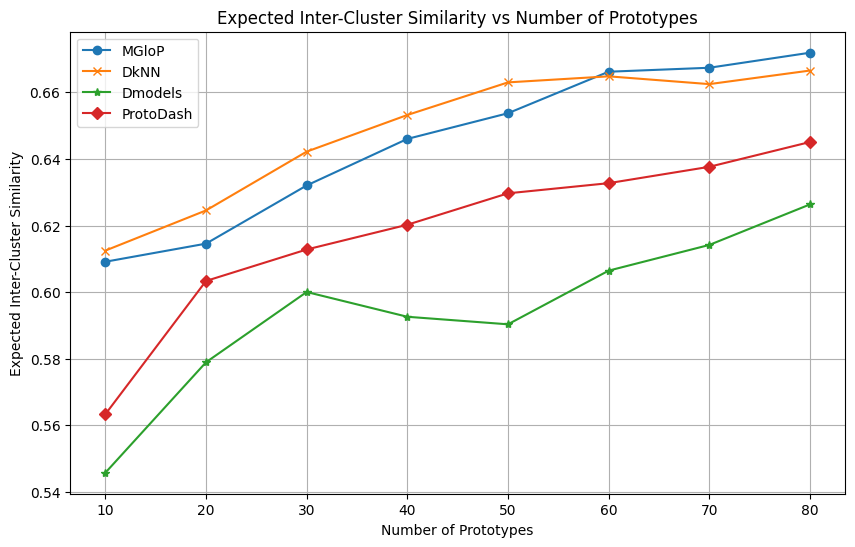

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


# Experiment with increasing number of prototypes
num_prototypes_list = range(10, 81, 10)
avg_similarities = []
avg_similarities1 = []
avg_similarities2 = []
avg_similarities3 = []

for i in tqdm(range(8)):
    mglop=list(all_protos_np[i].values())[0]
    dmodels=list(all_protos_np[i].values())[2]
    dknn=list(all_protos_np[i].values())[1]
    protodash=list(all_protos_np[i].values())[3]
    labels = cluster_by_prototypes(X_test, mglop)
    labels1 = cluster_by_prototypes(X_test, dknn)
    labels2 = cluster_by_prototypes(X_test, dmodels)
    labels3 = cluster_by_prototypes(X_test, protodash)
    avg_similarity = expected_inter_cluster_similarity(X_test, labels)
    avg_similarity1 = expected_inter_cluster_similarity(X_test, labels1)
    avg_similarity2 = expected_inter_cluster_similarity(X_test, labels2)
    avg_similarity3 = expected_inter_cluster_similarity(X_test, labels3)
    avg_similarities.append(avg_similarity)
    avg_similarities1.append(avg_similarity1)
    avg_similarities2.append(avg_similarity2)
    avg_similarities3.append(avg_similarity3)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_prototypes_list, avg_similarities, marker='o', label='MGloP')
plt.plot(num_prototypes_list, avg_similarities1, marker='x', label='DkNN')
plt.plot(num_prototypes_list, avg_similarities2, marker='*', label='Dmodels')
plt.plot(num_prototypes_list, avg_similarities3, marker='D', label='ProtoDash')
plt.xlabel('Number of Prototypes')
plt.ylabel('Expected Inter-Cluster Similarity')
plt.title('Expected Inter-Cluster Similarity vs Number of Prototypes')
plt.legend()
plt.grid(True)
plt.show()


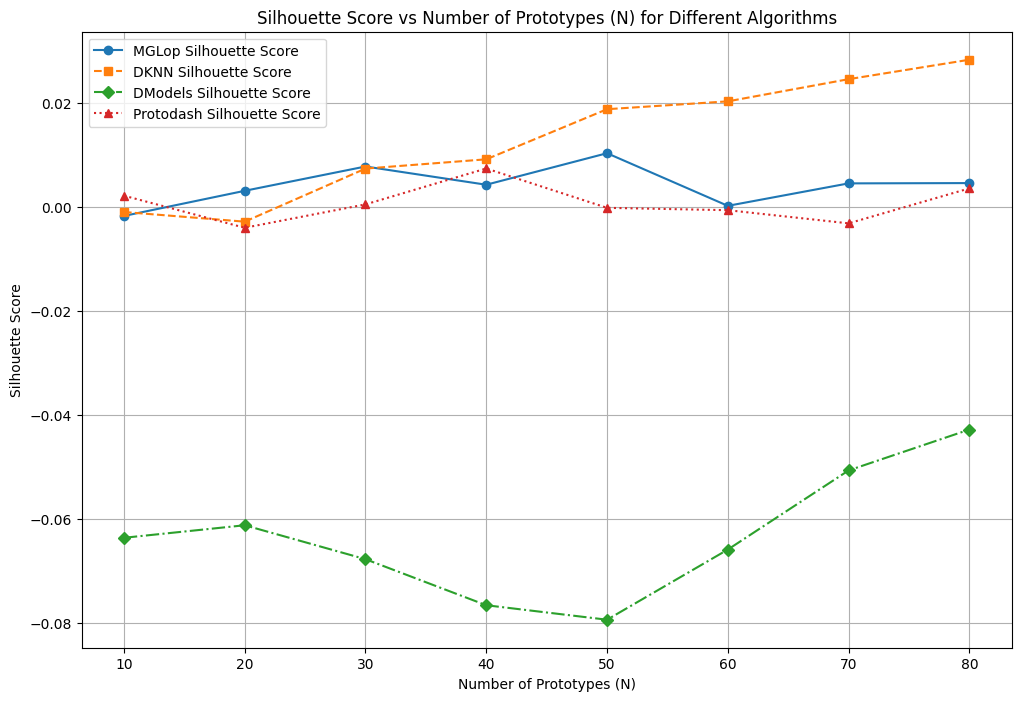

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(N_range, [item[1] for item in mglop_ev], marker='o', linestyle='-', label='MGLop Silhouette Score')
plt.plot(N_range, [item[1] for item in dknn_ev], marker='s', linestyle='--', label='DKNN Silhouette Score')
plt.plot(N_range, [item[1] for item in dmodels_ev], marker='D', linestyle='-.', label='DModels Silhouette Score')
plt.plot(N_range, [item[1] for item in protodash_ev], marker='^', linestyle=':', label='Protodash Silhouette Score')

plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Prototypes (N) for Different Algorithms")
plt.legend()
plt.grid(True)
# plt.savefig("Figures/silhouette_score_plot.pdf", format="pdf")
plt.show()

In [ ]:
elbow_method(X_test, mod_pred, range(8), X_test, mod_pred, proto=all_protos_np, k=0)

In [ ]:
list(all_protos_np[2].values())[0]